<!--NOTEBOOK_HEADER-->
*This notebook contains material from [cbe30338-2021](https://jckantor.github.io/cbe30338-2021);
content is available [on Github](https://github.com/jckantor/cbe30338-2021.git).*


<!--NAVIGATION-->
< [3.4 Implementing Controllers in Python](https://jckantor.github.io/cbe30338-2021/03.04-Implementing-Controllers.html) | [Contents](toc.html) | [3.6 Lab Assignment 3: Relay and PI Control](https://jckantor.github.io/cbe30338-2021/03.06-Lab-Assignment-PID-Control.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/03.05-Proportional-Integral-Control.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/03.05-Proportional-Integral-Control.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 3.5 Proportional (P) and Proportional-Integral (PI) Control

## 3.5.1 Learning Goals

* Be able be write expressions for proportional control, and proportional-integral control in position and velocity forms.
* Explain how the proportional and integral terms contribute to acheving feedback control to a setpoint.
* 

### 3.5.1.1 Descripton

Unlike on-off relay control, **proportional control** continuously adjusts the manipulated variable in proportion to the error between the setpoint and measured process variable.

\begin{align}
MV_k & = \bar{MV} + K_P(SP_k  - PV_k)
\end{align}

$K_p$ is a constant of proportionality called the **proportional control gain**. The **error signal** is the difference between the the measured process variable and setpoint,

\begin{align}
e_k & = PV_k - SP_k
\end{align}

for which the proportional control becomes

\begin{align}
MV_k & = \bar{MV} - K_P e_k
\end{align}

Note the presence of the negative sign indicating **negative feedback control**. Negative feedback means the control action suppresses deviations from the setpoint. Assuming the proportional gain is positive, and that the process being controlled exhibits a positive causal relationship between the manipulated variable and process variable, if the process variable grows above the setpoint, then the manipulated variable is decreased. If the process variable falls below the setpoint, then the manipulated variable is increased.

The constant term $\bar{MV}$ provides an estimate for a value of the manipulated variable required to maintain the desired setpoint. $\bar{MV}$ may be determined whatever information may be available, including trial and error adjustment. In subsequent notebooks we will see how $\bar{MV}$ is used in different ways when building practical control implementations.

### 3.5.1.2 Implementation

Our first implementation of feedback control will use a Python generator. An instance of a proportional controller is created by specifying the gain $K_P$, upper and lower bounds on the manipulated variable, and the offset value $\bar{MV}$.

In [16]:
def P(Kp, MV_min=0, MV_max=100, MV_bar=0):
    MV = MV_min
    while True:
        PV, SP = yield MV
        e = SP - PV
        MV = MV_bar + Kp*e

# create a controller instance with default parameter values
controller = P(3)

Let's see how well proportional control works when applied to the Temperature Control Laboratory. For this simulation we will arbitrarily set $\bar{MV} = 0$ and $K_p = 3.0$.

Note that the only line that has to change from the use of relay control is specification of the controller

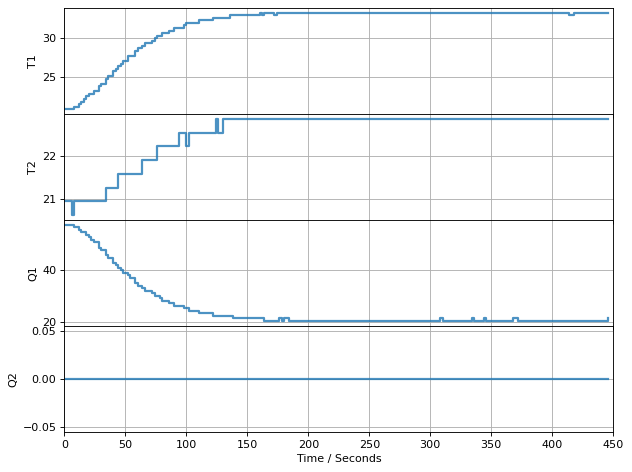

TCLab Model disconnected successfully.


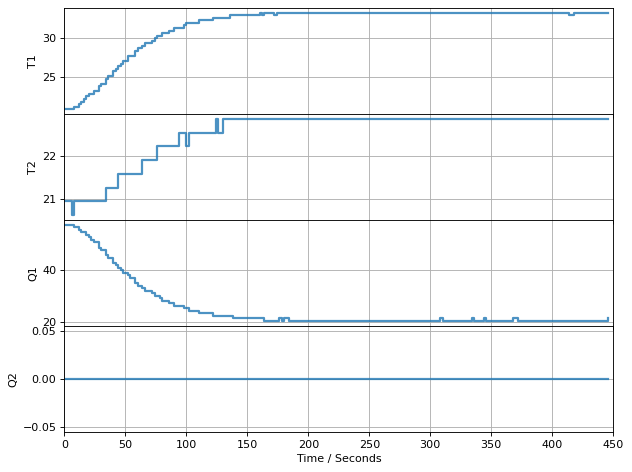

In [17]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup

# time horizon and time step
t_final = 450
t_step = 2

# constant setpoint
def sp(t):
    return 40.0

# perform experiment
TCLab = setup(connected=False, speedup=20)
with TCLab() as lab:
    
    # set up historian and plotter
    h = Historian(lab.sources)
    p = Plotter(h, t_final)
    
    # initialize manipulated variable
    lab.P1 = 200
    lab.Q1(next(controller))
    
    # main event loop
    for t in clock(t_final, t_step):
        T1 = lab.T1
        U1 = controller.send((T1, sp(t)))
        lab.Q1(U1)
        p.update(t)    

For systems without significant time delay and with properly chosen parameters, proportional control can achieve a fast response to changes in setpoint. Note, however, the steady state may be different than the desired setpoint, sometimes unacceptably different. This steady-state error a short-coming of purely proportional control.

<hr>

**Study Question:** Test the simulation for values of $K_p$ that are twice as large, and half as large as demonstrated above. What do you notice about the steady-state error between the desired setpoint and the measured process variable?

<hr>

## 3.5.2 Proportional-Integral (PI) Control

### 3.5.2.1 Position form

Given a process variable $PV$ and setpoint $SP$, proportional-integral control is defined by the relation

\begin{align}
MV(t) & = \bar{MV} + K_P(SP(t) - PV(t)) + K_I\int_{-\infty}^t (SP(t') - PV(t'))\,dt'
\end{align}

where **$K_P$ is the proportional gain** and **$K_I$ is the integral gain**. When implemented in discrete time with time steps of length $h$, the basic rule for proportional-integral control becomes

\begin{align}
MV_k & = \bar{MV} + K_P(SP_k  - PV_k) + h K_I\sum_{j=0}^{j=k}(SP_j -  PV_j)
\end{align}

This is the so-called **position form** of PI control. This formula specifies the value (or "position") of the manipulated variable stricly in terms of the current and past values of the **error** signal

\begin{align}
e_k & = PV_k - SP_k
\end{align}

Note the sign convention: A positive error occurs when the process variable is greater than the setpoint. W

The positioin form of PI control is generally not  used in practice.  

### 3.5.2.2 Velocity form

T

The actual implementation of PI control is normally done by computing how much the $MV$ should change at each time step. Defining the error at time $k$ as

\begin{align}
e_k & = SP_k - PV_k
\end{align}

then consecutive values of $MV$ are given by 

\begin{align}
MV_{k-1} & = \bar{MV} + K_p e_{k-1} + K_i \sum_{j=0}^{k-1} e_{j} \\
MV_{k} & = \bar{MV} + K_p e_{k} + K_i \sum_{j=0}^{k} e_{j}
\end{align}

Taking differences gives a practical formula for updating the value of $MV$ in response to measurements

\begin{align}
MV_{k} & = MV_{k-1} + K_p(e_{k} - e_{k-1}) + K_i e_{k}
\end{align}

In [6]:
def PI(Kp, Ki, MV_min, MV_max):
    MV = MV_min
    e_prev = 0
    while True:
        PV, SP = yield MV
        e = SP - PV
        MV += Kp*(e - e_prev) + Ki*e
        e_prev = e

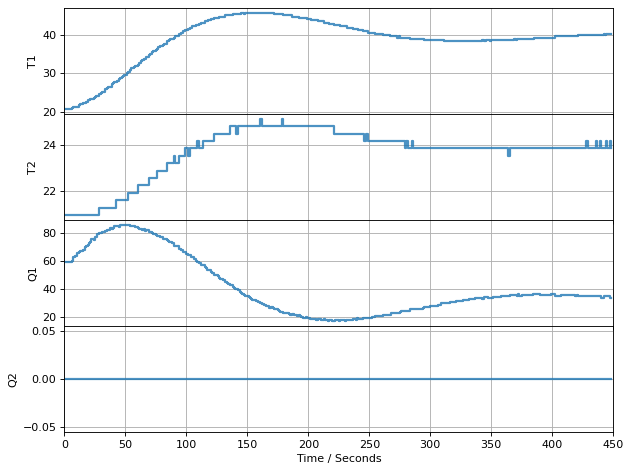

TCLab Model disconnected successfully.


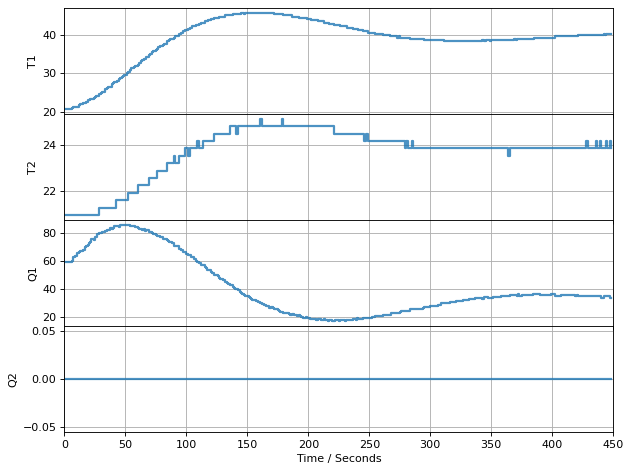

In [8]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup

TCLab = setup(connected=False, speedup=20)

# control parameters
controller = PI(3, 0.1, MV_min=0, MV_max=100)
next(controller)
T_SP = 40

# time horizon and time step
t_final = 450

# perform experiment
with TCLab() as lab:
    lab.P1 = 200
    h = Historian(lab.sources)
    p = Plotter(h, t_final)
    for t in clock(t_final):
        T1 = lab.T1
        U1 = controller.send((T1, T_SP))
        lab.Q1(U1)
        p.update(t)    

## 3.5.3 Anti-Reset Windup

In the next cell we're doing an experiment in which we increase the magnitude of the control gains to see if we an acheive even better control performance. Let's see how we do.

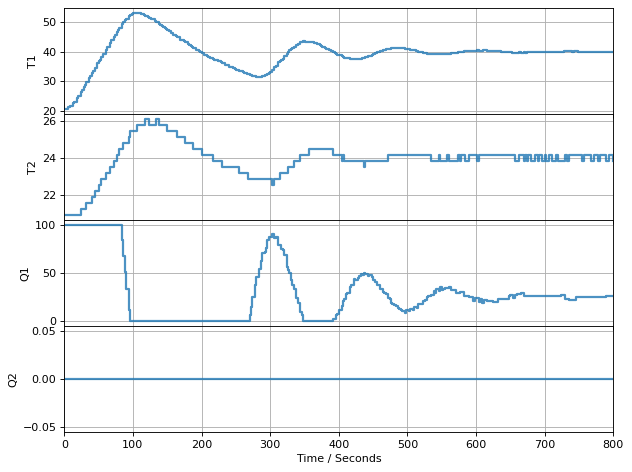

TCLab Model disconnected successfully.


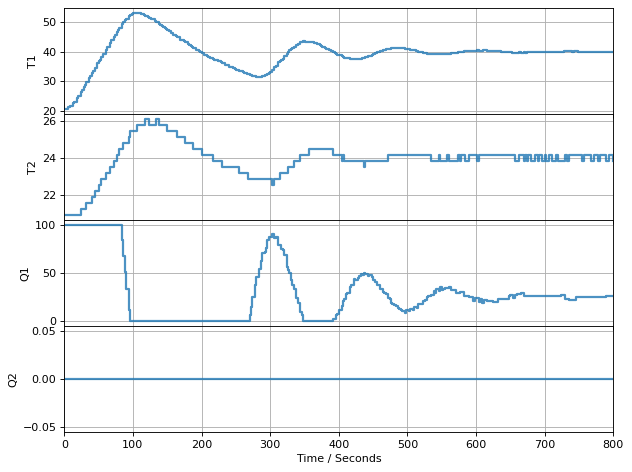

In [17]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup

# PI Control
def PI(Kp, Ki, MV_min, MV_max):
    MV = MV_min
    e_prev = 0
    while True:
        PV, SP = yield MV
        e = SP - PV
        MV += Kp*(e - e_prev) + Ki*e
        e_prev = e

# time horizon and time step
t_final = 800
t_step = 2

# control parameters
Kp = 10
Ki = 0.5
controller = PI(Kp, t_step*Ki, MV_min=0, MV_max=100)
next(controller)

# setpoint
T_SP = 40

# perform experiment
TCLab = setup(connected=False, speedup=20)
with TCLab() as lab:
    lab.P1 = 255
    h = Historian(lab.sources)
    p = Plotter(h, t_final)
    for t in clock(t_final, t_step):
        T1 = lab.T1
        U1 = controller.send((T1, T_SP))
        lab.Q1(U1)
        p.update(t)    

### 3.5.3.1 Integral windup

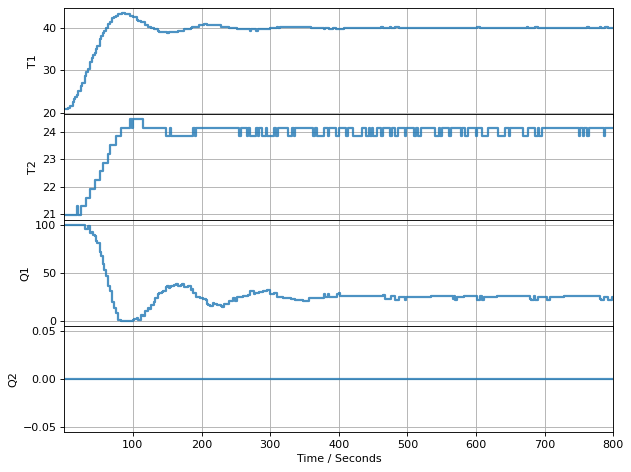

TCLab Model disconnected successfully.


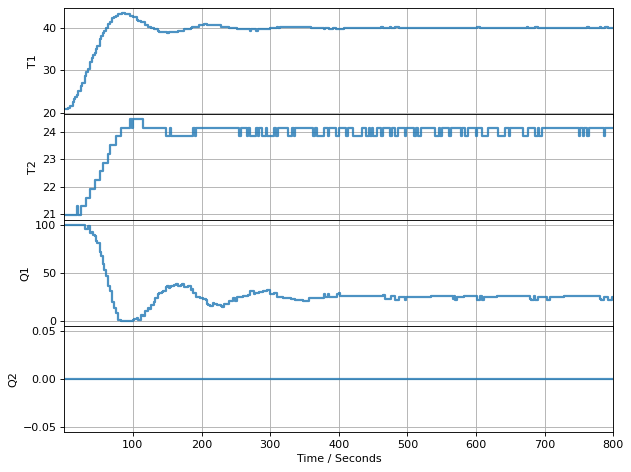

In [19]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup

# PI Control
def PI(Kp, Ki, MV_min, MV_max):
    MV = MV_min
    e_prev = 0
    while True:
        PV, SP = yield MV
        e = SP - PV
        MV += Kp*(e - e_prev) + Ki*e
        MV = max(MV_min, min(MV_max, MV))
        e_prev = e

# time horizon and time step
t_final = 800
t_step = 2

# control parameters
Kp = 10
Ki = 0.5
controller = PI(Kp, t_step*Ki, MV_min=0, MV_max=100)
next(controller)

# setpoint
T_SP = 40

# perform experiment
TCLab = setup(connected=False, speedup=20)
with TCLab() as lab:
    lab.P1 = 255
    h = Historian(lab.sources)
    p = Plotter(h, t_final)
    for t in clock(t_final, t_step):
        T1 = lab.T1
        U1 = controller.send((T1, T_SP))
        lab.Q1(U1)
        p.update(t)    

<!--NAVIGATION-->
< [3.4 Implementing Controllers in Python](https://jckantor.github.io/cbe30338-2021/03.04-Implementing-Controllers.html) | [Contents](toc.html) | [3.6 Lab Assignment 3: Relay and PI Control](https://jckantor.github.io/cbe30338-2021/03.06-Lab-Assignment-PID-Control.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/03.05-Proportional-Integral-Control.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/03.05-Proportional-Integral-Control.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>